## Fitting data to a list of possible distributions

Code modified from: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
#import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm

from cycler import cycler

In [2]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Distributions to check
    dist_list = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    dist_list = [st.lognorm]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in dist_list:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)


In [3]:
def make_pdf(dist, params, data, size=10000):
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get start and end points of distribution
    start = min(data) 
    end = max(data) 
    
    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [4]:
# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
data = pd.Series(np.loadtxt("/home/anagainaru/work/scheduler_simulator/github/SpeculativeScheduling/workload/accre_data/ACCRE/VBMQA.out", delimiter=' '))

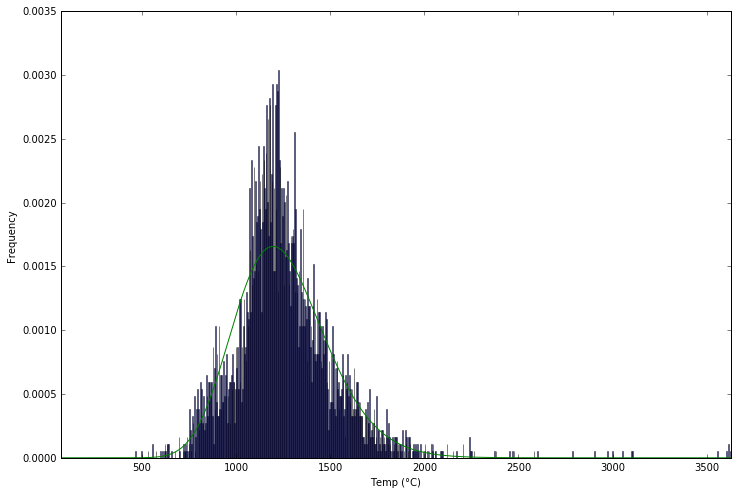

In [5]:
# Plot for comparison fits for all selected distributions

plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=1000, normed=True, alpha=0.5)#, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 1000, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

In [6]:
# plot the parameters for the lognorm fit

shape = best_fit_params[0]
loc = best_fit_params[1]
scale = best_fit_params[2]

print(best_fit_params)

mu = int(lognorm.mean(shape, loc, scale))
sigma = int(lognorm.std(shape, loc, scale))
print(mu, sigma)

(0.15719945316553743, -316.25800118453867, 1550.0297439091075)
1253 248


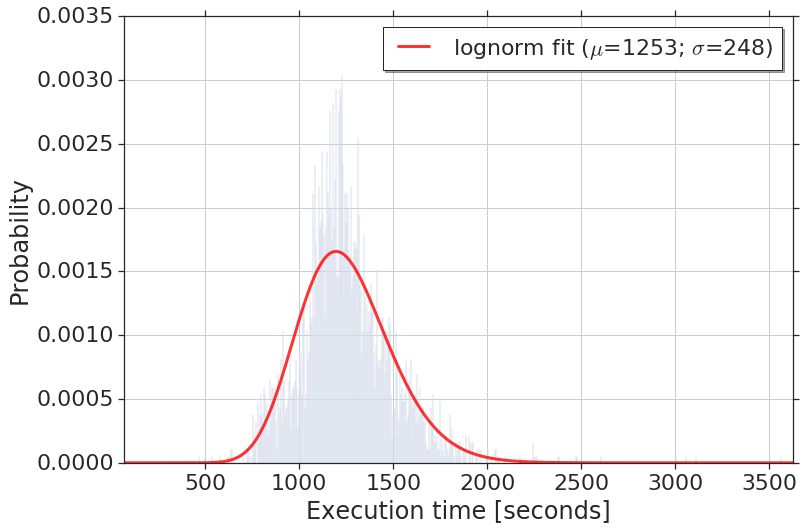

In [7]:
# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params, data)

# Display
plt.figure(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

ax = pdf.plot(lw=3, color="red", alpha=0.8, legend=True)
data.plot(kind='hist', bins=1000, normed=True, alpha=0.3)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

plt.legend(['%s fit ($\mu$=%d; $\sigma$=%d)' %(best_dist.name, mu, sigma)], shadow=True)
plt.grid(True)
ax.set_xlabel('Execution time [seconds]')
ax.set_ylabel('Probability')
#plt.savefig('VBMQA.png')